In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/butterfly-image-classification/Training_set.csv
/kaggle/input/butterfly-image-classification/Testing_set.csv
/kaggle/input/butterfly-image-classification/test/Image_747.jpg
/kaggle/input/butterfly-image-classification/test/Image_561.jpg
/kaggle/input/butterfly-image-classification/test/Image_345.jpg
/kaggle/input/butterfly-image-classification/test/Image_2566.jpg
/kaggle/input/butterfly-image-classification/test/Image_1593.jpg
/kaggle/input/butterfly-image-classification/test/Image_844.jpg
/kaggle/input/butterfly-image-classification/test/Image_1975.jpg
/kaggle/input/butterfly-image-classification/test/Image_270.jpg
/kaggle/input/butterfly-image-classification/test/Image_526.jpg
/kaggle/input/butterfly-image-classification/test/Image_968.jpg
/kaggle/input/butterfly-image-classification/test/Image_2104.jpg
/kaggle/input/butterfly-image-classification/test/Image_1769.jpg
/kaggle/input/butterfly-image-classification/test/Image_2008.jpg
/kaggle/input/butterfly-image-classific

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Load data
train_label = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")
test_label = pd.read_csv("/kaggle/input/butterfly-image-classification/Testing_set.csv")
butterfly_list = train_label["label"].unique()
num_classes = len(butterfly_list)
train_dir = "/kaggle/input/butterfly-image-classification/train/"
test_dir = "/kaggle/input/butterfly-image-classification/test/"
image_size = 128

In [4]:
# Data preprocessing function
def preprocess(image_directory, image_name, size=image_size):
    image = cv2.imread(os.path.join(image_directory, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (size, size))
    return image

In [5]:
# Convert string labels to integer labels
label_to_int = {label: idx for idx, label in enumerate(butterfly_list)}
train_labels_int = [label_to_int[label] for label in train_label['label']]

# Convert integer labels to one-hot encoded labels
train_labels_encoded = to_categorical(train_labels_int, num_classes=num_classes)


In [6]:
# Load and preprocess training data
train_data = []
for filename, label in zip(train_label['filename'], train_labels_int):
    image = preprocess(train_dir, filename)
    train_data.append(image)

train_data = np.array(train_data)

In [7]:
# Create the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(150, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [8]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(train_data / 255.0, train_labels_encoded, epochs=7, batch_size=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 150)               8

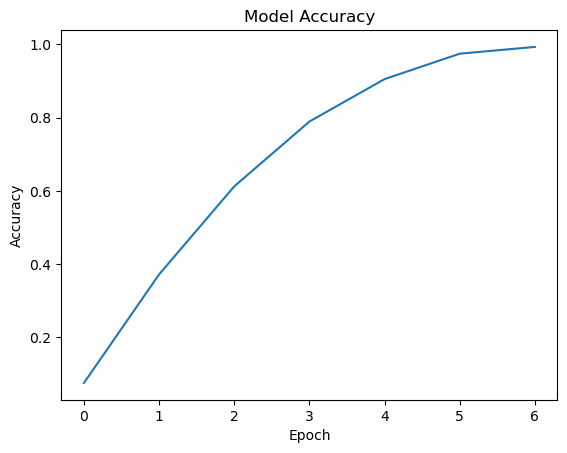

In [9]:
# Plot training history
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [10]:
# Save predictions to CSV
test_predictions = []
for filename in test_label['filename']:
    image = preprocess(test_dir, filename)
    image = np.expand_dims(image, axis=0) / 255.0
    prediction = model.predict(image)
    predicted_label = butterfly_list[np.argmax(prediction)]
    test_predictions.append(predicted_label)

test_label['predicted_label'] = test_predictions
test_label.to_csv("Prediction.csv", index=False)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


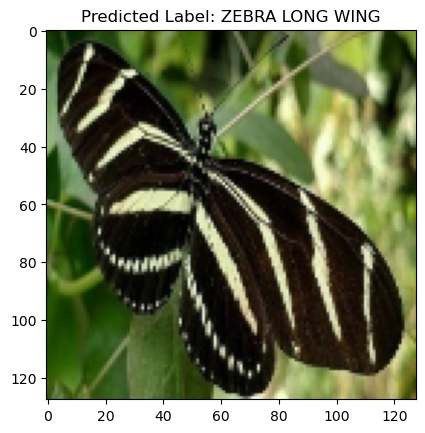

In [11]:
# Display an example image and its predicted label
example_image = preprocess(test_dir, "Image_10.jpg")
example_image = np.expand_dims(example_image, axis=0) / 255.0
predicted_label = butterfly_list[np.argmax(model.predict(example_image))]

plt.imshow(example_image[0])
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

Validation Accuracy: 0.20


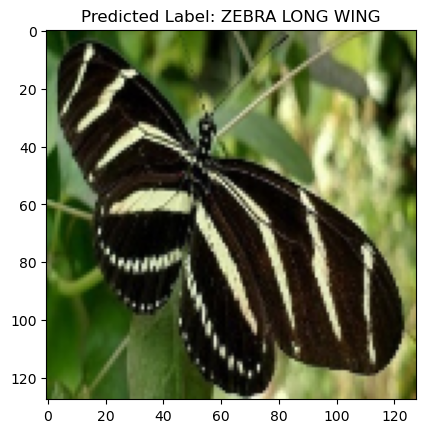

In [12]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load data
train_label = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")
test_label = pd.read_csv("/kaggle/input/butterfly-image-classification/Testing_set.csv")
butterfly_list = train_label["label"].unique()
train_dir = "/kaggle/input/butterfly-image-classification/train/"
test_dir = "/kaggle/input/butterfly-image-classification/test/"

# Data preprocessing function
def preprocess(image_directory, image_name, size=128):
    image = cv2.imread(os.path.join(image_directory, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (size, size))
    return image

# Extract color histogram features from images
def extract_histogram_features(images):
    features = []
    for img in images:
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.append(hist)
    return np.array(features)

# Load and preprocess training data
train_data = []
train_labels = []
for idx, row in train_label.iterrows():
    img = preprocess(train_dir, row['filename'])
    train_data.append(img)
    train_labels.append(row['label'])

train_data = np.array(train_data)
train_features = extract_histogram_features(train_data)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels_encoded, test_size=0.2, random_state=42)

# Train Support Vector Machine classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions = svm_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Generate predictions for test set
test_data = []
for idx, row in test_label.iterrows():
    img = preprocess(test_dir, row['filename'])
    test_data.append(img)

test_data = np.array(test_data)
test_features = extract_histogram_features(test_data)
test_predictions_encoded = svm_classifier.predict(test_features)
test_predictions = label_encoder.inverse_transform(test_predictions_encoded)

# Save predictions to CSV
test_label['predicted_label'] = test_predictions
test_label.to_csv("Prediction_SVM_Histogram.csv", index=False)

# Display an example image and its predicted label
example_image = preprocess(test_dir, "Image_10.jpg")
example_image = np.expand_dims(example_image, axis=0)
example_features = extract_histogram_features(example_image)
predicted_label_idx = svm_classifier.predict(example_features)[0]
predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]

plt.imshow(example_image[0])
plt.title(f"Predicted Label: {predicted_label}")
plt.show()


Validation Accuracy: 0.42


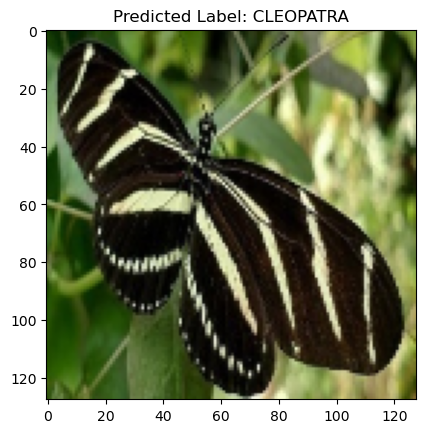

In [13]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load data
train_label = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")
test_label = pd.read_csv("/kaggle/input/butterfly-image-classification/Testing_set.csv")
butterfly_list = train_label["label"].unique()
train_dir = "/kaggle/input/butterfly-image-classification/train/"
test_dir = "/kaggle/input/butterfly-image-classification/test/"

# Data preprocessing function
def preprocess(image_directory, image_name, size=128):
    image = cv2.imread(os.path.join(image_directory, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (size, size))
    return image

# Extract color histogram features from images
def extract_histogram_features(images):
    features = []
    for img in images:
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.append(hist)
    return np.array(features)

# Load and preprocess training data
train_data = []
train_labels = []
for idx, row in train_label.iterrows():
    img = preprocess(train_dir, row['filename'])
    train_data.append(img)
    train_labels.append(row['label'])

train_data = np.array(train_data)
train_features = extract_histogram_features(train_data)

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels_encoded, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions = rf_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Generate predictions for test set
test_data = []
for idx, row in test_label.iterrows():
    img = preprocess(test_dir, row['filename'])
    test_data.append(img)

test_data = np.array(test_data)
test_features = extract_histogram_features(test_data)
test_predictions_encoded = rf_classifier.predict(test_features)
test_predictions = label_encoder.inverse_transform(test_predictions_encoded)

# Save predictions to CSV
test_label['predicted_label'] = test_predictions
test_label.to_csv("Prediction_RF_Histogram.csv", index=False)

# Display an example image and its predicted label
example_image = preprocess(test_dir, "Image_10.jpg")
example_image = np.expand_dims(example_image, axis=0)
example_features = extract_histogram_features([example_image[0]])  # Pass a list with one image
predicted_label_idx = rf_classifier.predict(example_features)[0]
predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]

plt.imshow(example_image[0])
plt.title(f"Predicted Label: {predicted_label}")
plt.show()